In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# 1. Interest Point Detection (SIFT)
def detect_sift_keypoints(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # SIFT detector
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Draw keypoints
    img_sift = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2_imshow(img_sift)
    return img_sift, keypoints, descriptors

# 2. Feature Matching using ORB + BFMatcher

def match_features(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Brute-force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
    print("ORB Feature Matching")
    cv2_imshow(matched_img)

# 3. Contour Detection using Watershed

def contour_with_watershed(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [0, 0, 255]  # Red boundary

    print('Watershed Contours')
    cv2_imshow(img)

if __name__ == "__main__":
    # Replace these image paths with your own
    image_path1 = 'imgblah.jpg'
    image_path2 = 'imgbleh.jpg'

    print("[1] Detecting SIFT Keypoints...")
    detect_sift_keypoints(image_path1)

    print("[2] Matching Features with ORB + BFMatcher...")
    match_features(image_path1, image_path2)

    print("[3] Contour Detection with Watershed...")
    contour_with_watershed(image_path1)




In [ ]:
#TASK2
import torchvision
import torchvision.transforms as transforms
import torch

# Transform: normalize the dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize for ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Download and load training & testing data
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = trainset.classes


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 and ResNet34 and modify for 100 classes
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)
resnet18 = resnet18.to(device)

resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)
resnet34 = resnet34.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weig

In [ ]:
import torch.optim as optim
import time

def train_model(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[{epoch + 1}] loss: {running_loss / len(trainloader):.4f}")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_18 = optim.Adam(resnet18.parameters(), lr=0.001)
optimizer_34 = optim.Adam(resnet34.parameters(), lr=0.001)

# Train ResNet18
print("Training ResNet18:")
start_18 = time.time()
train_model(resnet18, trainloader, criterion, optimizer_18, epochs=10)
end_18 = time.time()

# Train ResNet34
print("Training ResNet34:")
start_34 = time.time()
train_model(resnet34, trainloader, criterion, optimizer_34, epochs=10)
end_34 = time.time()


Training ResNet18:
[1] loss: 1.9325
[2] loss: 1.1677
[3] loss: 0.8225
[4] loss: 0.5761
[5] loss: 0.3905
[6] loss: 0.2890
[7] loss: 0.2162
[8] loss: 0.1894
[9] loss: 0.1626
[10] loss: 0.1633
Training ResNet34:
[1] loss: 2.2733
[2] loss: 1.3846
[3] loss: 1.0303
[4] loss: 0.7709
[5] loss: 0.5555
[6] loss: 0.4077
[7] loss: 0.3056
[8] loss: 0.2321
[9] loss: 0.1988
[10] loss: 0.1754


In [ ]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_total += loss.item()

    accuracy = 100 * correct / total
    avg_loss = loss_total / len(testloader)
    return accuracy, avg_loss

# Evaluate both models
acc_18, loss_18 = evaluate_model(resnet18, testloader)
acc_34, loss_34 = evaluate_model(resnet34, testloader)

inference_time_18 = end_18 - start_18
inference_time_34 = end_34 - start_34


In [ ]:
print("\n--- Comparison Summary ---")
print(f"ResNet18 - Accuracy: {acc_18:.2f}%, Loss: {loss_18:.4f}, Training Time: {inference_time_18:.2f} sec")
print(f"ResNet34 - Accuracy: {acc_34:.2f}%, Loss: {loss_34:.4f}, Training Time: {inference_time_34:.2f} sec")



--- Comparison Summary ---
ResNet18 - Accuracy: 67.23%, Loss: 1.6011, Training Time: 1622.38 sec
ResNet34 - Accuracy: 65.17%, Loss: 1.6839, Training Time: 2514.74 sec


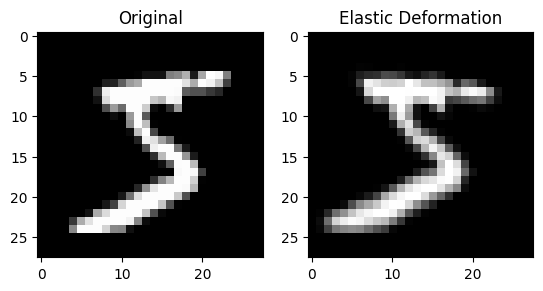

Prototypical Network: {'accuracy': 0.52, 'precision': 0.4011904761904762, 'recall': 0.5199999999999999, 'f1_score': 0.4488733488733489}
Matching Network: {'accuracy': 0.52, 'precision': 0.41166666666666674, 'recall': 0.5199999999999999, 'f1_score': 0.4556643356643357}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


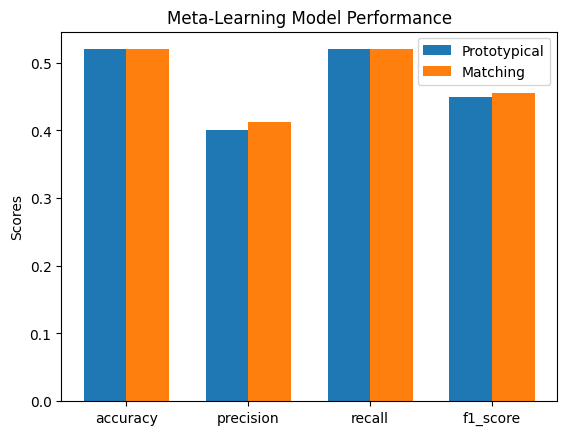

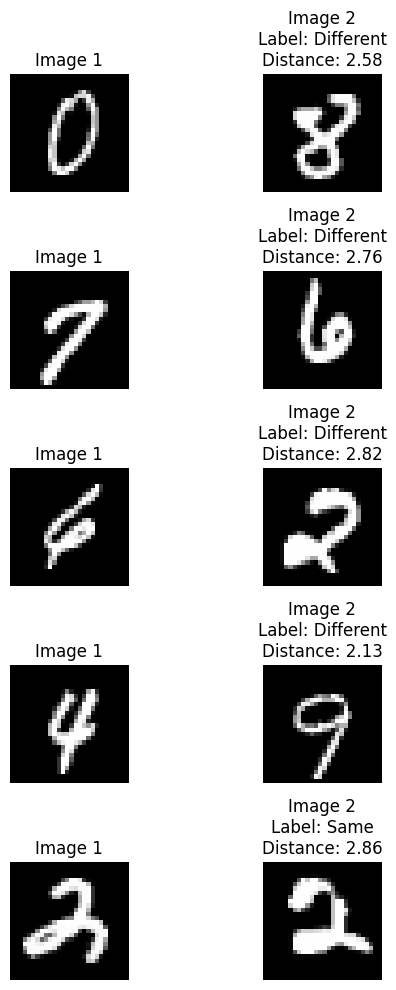

In [ ]:
#Task2.2
# Meta-Learning on MNIST Dataset - Google Colab Version

# ===============================
# Step 1: Install & Import Libraries
# ===============================
!pip install torchvision matplotlib scikit-learn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import random
from sklearn.metrics import classification_report

# ===============================
# Step 2: Data Preprocessing
# ===============================
transform = transforms.Compose([
    transforms.ToTensor(),
])

def elastic_transform(image, alpha, sigma):
    image = image.numpy()
    shape = image.shape[1:]
    dx = ndimage.gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = ndimage.gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    distorted = ndimage.map_coordinates(image[0], indices, order=1).reshape(1, *shape)
    return torch.tensor(distorted, dtype=torch.float32)

# Load Dataset
dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Apply Elastic Deformation on Sample
sample_img, _ = dataset[0]
elastic_img = elastic_transform(sample_img, alpha=36, sigma=6)

plt.subplot(1,2,1)
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(elastic_img.squeeze(), cmap='gray')
plt.title("Elastic Deformation")
plt.show()

# Split Dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ===============================
# 🧠Step 3: Meta-Learning Utilities
# ===============================
def sample_episode(dataset, N=5, K=1, Q=5):
    class_to_indices = {}
    for idx, (img, label) in enumerate(dataset):
        class_to_indices.setdefault(label, []).append(idx)

    selected_classes = random.sample(list(class_to_indices.keys()), N)
    support_set, query_set, support_labels, query_labels = [], [], [], []

    for new_label, cls in enumerate(selected_classes):
        indices = random.sample(class_to_indices[cls], K + Q)
        for i in range(K):
            support_set.append(dataset[indices[i]][0])
            support_labels.append(new_label)
        for i in range(K, K+Q):
            query_set.append(dataset[indices[i]][0])
            query_labels.append(new_label)

    return torch.stack(support_set), torch.tensor(support_labels), \
           torch.stack(query_set), torch.tensor(query_labels)

# ===============================
#  Step 4: Prototypical Network
# ===============================
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

def compute_prototypes(embeddings, labels, N):
    prototypes = []
    for i in range(N):
        proto = embeddings[labels == i].mean(0)
        prototypes.append(proto)
    return torch.stack(prototypes)

def evaluate_prototypical(model, support_x, support_y, query_x, query_y, N):
    model.eval()
    with torch.no_grad():
        support_embed = model(support_x)
        query_embed = model(query_x)
        prototypes = compute_prototypes(support_embed, support_y, N)
        dists = torch.cdist(query_embed, prototypes)
        preds = torch.argmin(dists, dim=1)
        return preds, query_y

# ===============================
#  Siamese Network (Few-shot & One-shot)
# ===============================
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = SimpleCNN()

    def forward_once(self, x):
        return self.cnn(x)

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss

# ===============================
#  Matching Network (One-shot)
# ===============================
def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(1), b.unsqueeze(0), dim=2)

def matching_prediction(query, support, support_labels):
    sims = cosine_similarity(query, support)
    softmax_weights = F.softmax(sims, dim=1)
    predictions = torch.matmul(softmax_weights, F.one_hot(support_labels).float())
    return torch.argmax(predictions, dim=1)

# ===============================
#  Step 5: Train & Evaluate All Models
# ===============================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1_score': f1_score(y_true, y_pred, average='macro')
    }

# Run Evaluation
N, K, Q = 5, 1, 5
support_x, support_y, query_x, query_y = sample_episode(test_dataset, N, K, Q)

proto_model = SimpleCNN()
siamese_model = SiameseNetwork()
proto_preds, y_true = evaluate_prototypical(proto_model, support_x, support_y, query_x, query_y, N)
proto_metrics = evaluate_metrics(y_true.numpy(), proto_preds.numpy())

support_embed = proto_model(support_x)
query_embed = proto_model(query_x)
matching_preds = matching_prediction(query_embed, support_embed, support_y)
match_metrics = evaluate_metrics(query_y.numpy(), matching_preds.numpy())

print("Prototypical Network:", proto_metrics)
print("Matching Network:", match_metrics)

# ===============================
#  Visualization: Performance Comparison
# ===============================
labels = list(proto_metrics.keys())
proto_vals = list(proto_metrics.values())
match_vals = list(match_metrics.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, proto_vals, width, label='Prototypical')
ax.bar(x + width/2, match_vals, width, label='Matching')

ax.set_ylabel('Scores')
ax.set_title('Meta-Learning Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# 🔍 Siamese Network Pair Visualization (Positive vs Negative)

def visualize_siamese_pairs(model, dataset, num_pairs=5):
    model.eval()
    fig, axes = plt.subplots(num_pairs, 2, figsize=(6, 2*num_pairs))

    for i in range(num_pairs):
        same_class = random.choice([True, False])
        class_label = random.choice(range(10))
        class_indices = [i for i, (img, lbl) in enumerate(dataset) if lbl == class_label]

        if same_class:
            idx1, idx2 = random.sample(class_indices, 2)
            label = 0  # similar
        else:
            idx1 = random.choice(class_indices)
            other_class = random.choice([c for c in range(10) if c != class_label])
            other_indices = [i for i, (img, lbl) in enumerate(dataset) if lbl == other_class]
            idx2 = random.choice(other_indices)
            label = 1  # dissimilar

        img1, _ = dataset[idx1]
        img2, _ = dataset[idx2]
        out1, out2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
        distance = F.pairwise_distance(out1, out2).item()

        axes[i, 0].imshow(img1.squeeze(), cmap='gray')
        axes[i, 0].set_title("Image 1")
        axes[i, 1].imshow(img2.squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Image 2\nLabel: {'Same' if label==0 else 'Different'}\nDistance: {distance:.2f}")
        for ax in axes[i]: ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run Visualization
visualize_siamese_pairs(siamese_model, test_dataset)



